Authors       | Email                  |
:--------------|:----------------------|
Rezwanul      | rezwanul.cse@gmail.com |


## Problem: Facical Recognition.
### Problem class: Image Classification

#### The Face recognition dataset is provided by AT&T Laboratories, Cambridge.
### Problem dataset link: [Face recognition](http://www.face-rec.org/databases/)

### Problem description:

 Facial Recognition system.

### Problem Task:  Build and train a Siamese neural network to predict the face using One shot learning technique.

# Import Libraries

In [1]:
import os
import random
import shutil
import piexif
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import numpy as np

import cv2

from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras import backend as K

Using TensorFlow backend.


# Loading data

In [2]:
face_cascades = cv2.CascadeClassifier('data/pre-trained_cascade/haarcascade_frontalface_default.xml')

In [3]:
# face detection function
def detect_faces(img, draw_box=True):
    # Convert image to grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # detect faces
    faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor=1.6)
    
    # Draw bounding around detected faces
    for (x, y, width, height) in faces:
        if draw_box:
            cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 5)
    face_box = img[y : y + height, x : x + width]
    face_coords = [x, y, width, height]
    
    return img, face_box, face_coords

In [4]:
sample_face_dir = 'data/sample_faces'
detected_face_dir = sample_face_dir + '/detected_faces/' 

files = os.listdir(sample_face_dir)
images = [file for file in files if 'jpg' in file]

for image in images:
    img = cv2.imread(sample_face_dir + '/' + image)
    detected_faces, _, _ = detect_faces(img)
    
    cv2.imwrite(detected_face_dir + image, detected_faces)
#     cv2.imshow(img, detected_faces)

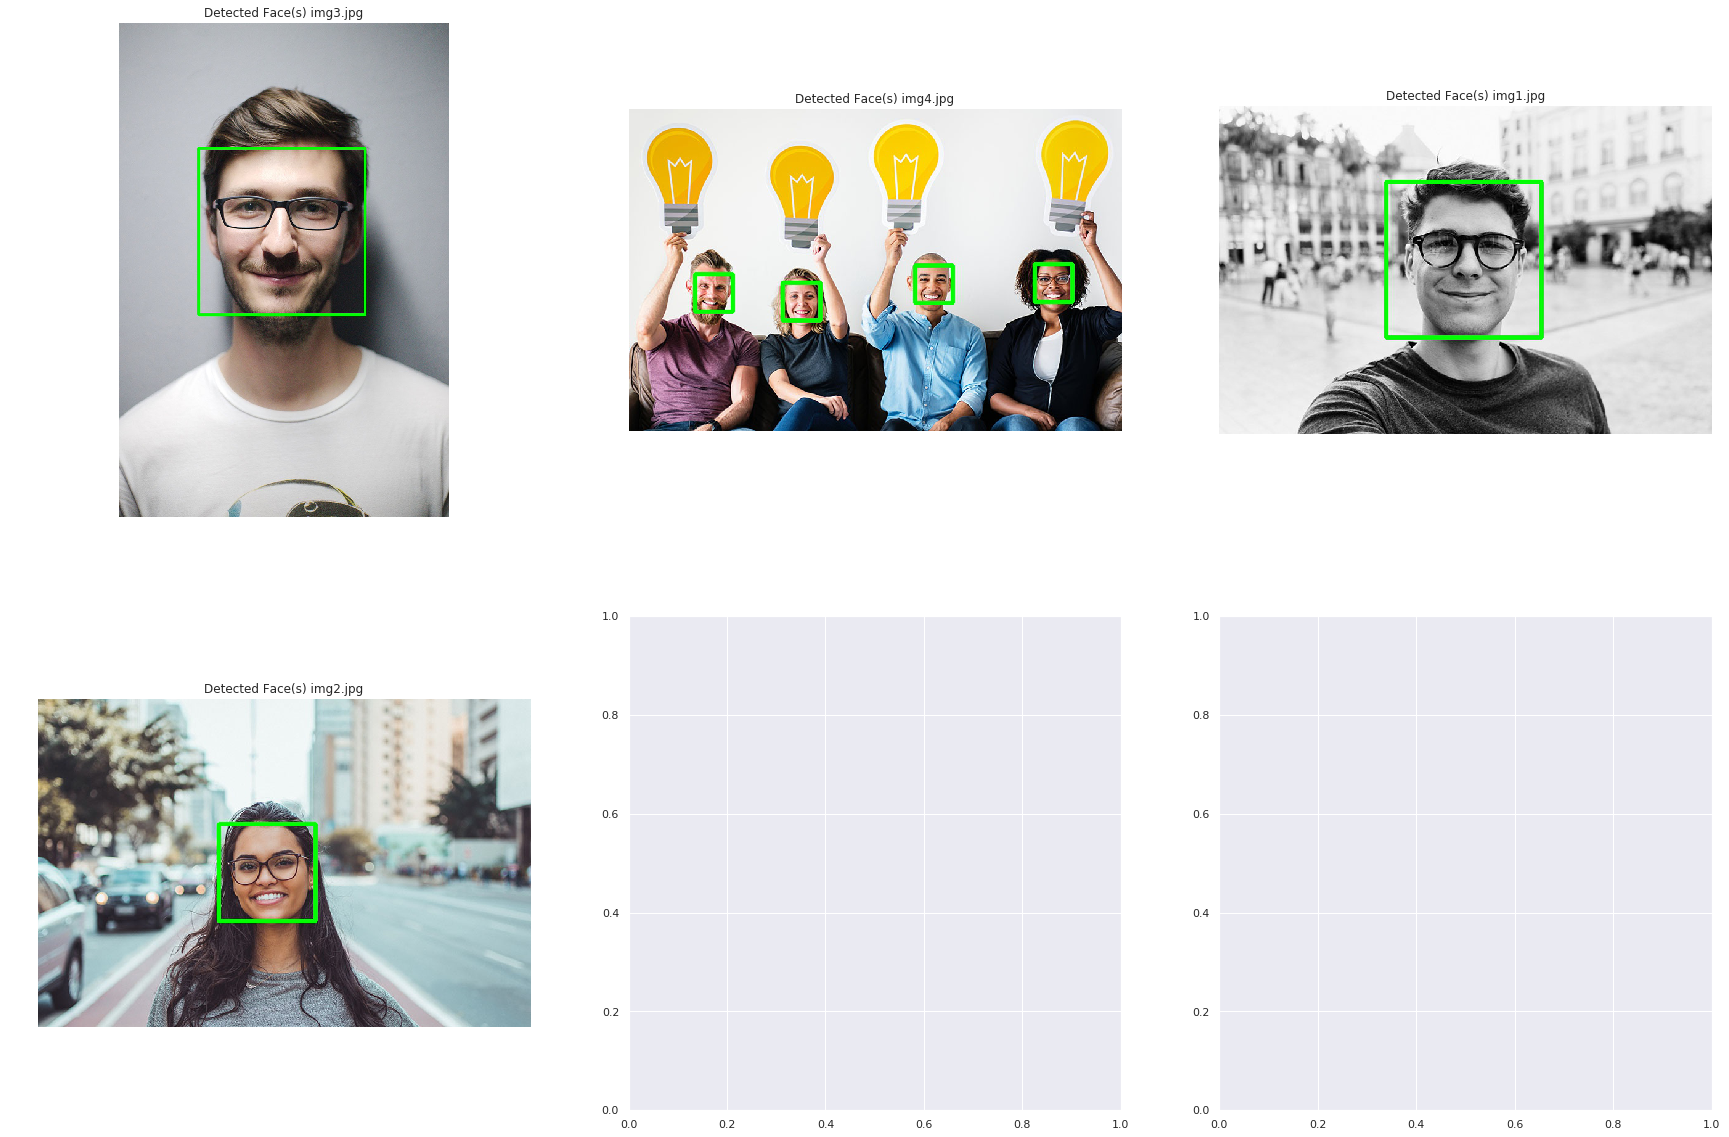

In [5]:
detected_files = os.listdir(detected_face_dir)
detected_images = [file for file in files if 'jpg' in file]

fix, ax = plt.subplots(2, 3, figsize=(30, 20))

for idx, img in enumerate(detected_images):
    img_read = plt.imread(detected_face_dir + '/' + img)
    ax[int(idx / 3), idx % 3].imshow(img_read)
    ax[int(idx / 3), idx % 3].axis('off')
    ax[int(idx / 3), idx % 3].set_title('Detected Face(s) ' + img)
plt.show()

In [6]:
faces_dir = 'data/att_faces/'

X_train, Y_train = [], []
X_test, Y_test = [], []

# Get list of subfolders from faces_dir
# Each subfolder contains images from one subject
subfolders = sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

# Iterate through the list of subfolders (subjects)
# Idx is the subject ID
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = load_img(folder + '/' + file, color_mode='grayscale')
        img = img_to_array(img).astype('float32') / 255
        if idx < 35:
            X_train.append(img)
            Y_train.append(idx)
        else: 
            X_test.append(img)
            Y_test.append(idx - 35)

In [7]:
X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

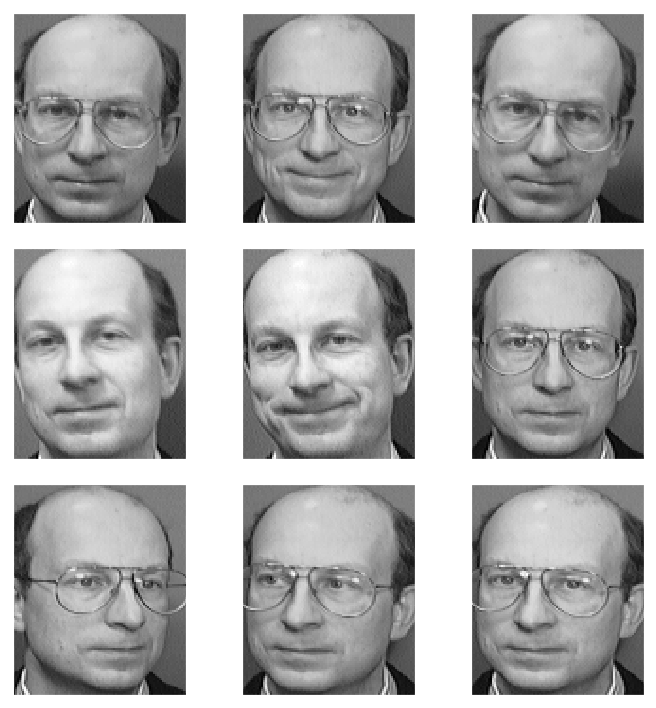

In [8]:
subject_idx = 4
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10))

subject_img_idx = np.where(Y_train == subject_idx)[0].tolist()

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Insight:
# Each photo of the subject was taken at a different angle, and the subject had different facial expressions. 
# In some photos, we can also see that the subject removed his glasses. There's certainly a lot of variation from image to image.

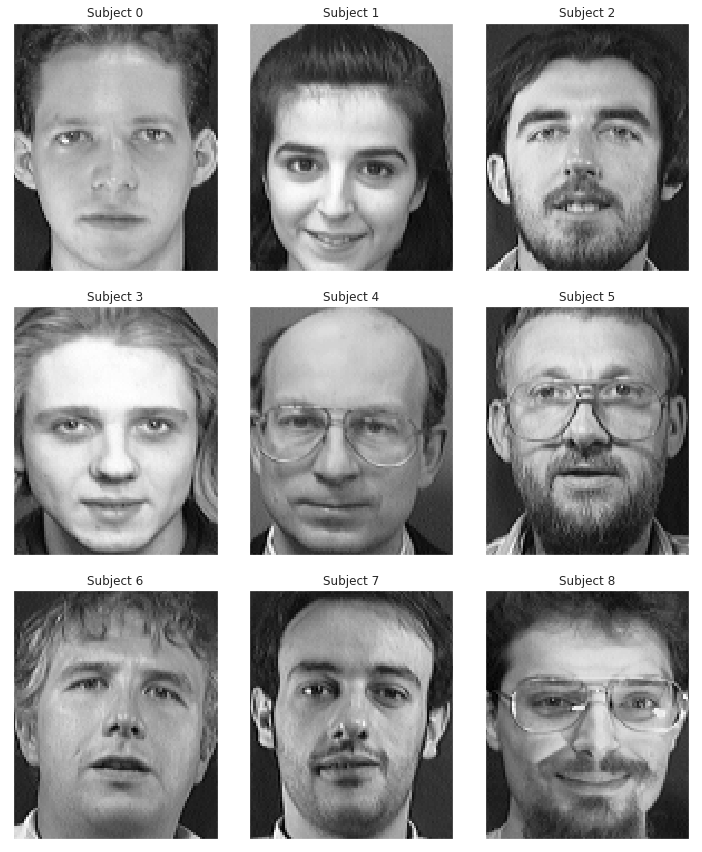

In [9]:
# plot the first 9 subjects
subjects = range(10)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 12))

subject_img_idx = [np.where(Y_train == i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Subject {i}")
plt.tight_layout()
plt.show()

# Model Building

> #### Siamese neural network

![Siamese neural network](images/Siamese_neural_network_2.png)

In [10]:
def create_shared_network(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    
    return model

In [11]:
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)

In [12]:
# Top layers
input_top = Input(shape=input_shape)
# Bottom layers
input_bottom = Input(shape=input_shape)

In [13]:
output_top = shared_network(input_top)

output_bottom = shared_network(input_bottom)

![courrent siamese network](images/current_siamese_network.png)

In [ ]:
# Combine the output from the top and bottom, and to measure the Euclidean distance between the two outputs. Remember, 
# the outputs from the top and bottom at this point are 128 x 1-dimensional vectors, representing the lower-dimensional 
# feature space.

In [14]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [15]:
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])

In [16]:
model = Model(inputs=[input_top, input_bottom], outputs=distance)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

# Model Training

In [51]:
def create_pairs(X, Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    mini_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
    
    for c in range(num_classes):
        for n in range(mini_images):
            # Create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
            # Create negative pair
            # list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # Select a random class from the negative list:
            # This class will be used to form the negative pair
            neg_c = random.sample(neg_list, 1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            
            pairs.append((img1, img2))
            labels.append(0)
    
    return np.array(pairs), np.array(labels)

In [52]:
num_classes = len(np.unique(Y_train))
training_pairs, training_labels = create_pairs(X_train, Y_train, len(np.unique(Y_train)))

test_pairs, test_labels = create_pairs(X_test, Y_test, len(np.unique(Y_test)))

### Loss function

In [53]:
def contrastive_loss(Y_true, D):
    margin = 1
    
    return K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin - D), 0))

In [54]:
model.compile(loss=contrastive_loss, optimizer='adam')

In [1]:
model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
          batch_size=128,
          epochs=10)

NameError: name 'model' is not defined

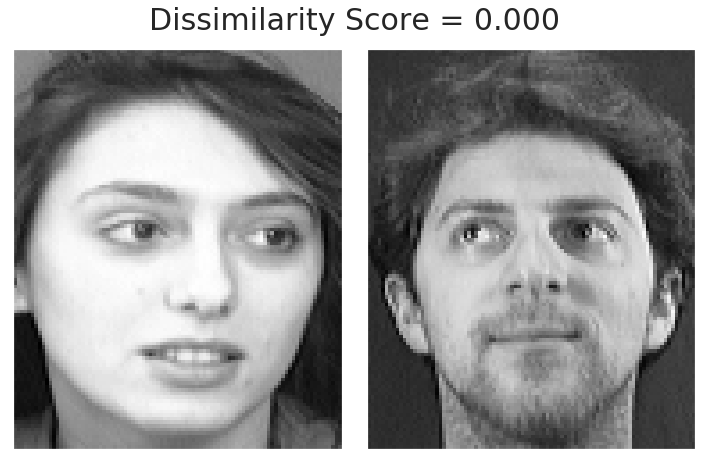

In [58]:
idx1, idx2 = 31, 29
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle(f"Dissimilarity Score = {dissimilarity:.3f}", size=30)
plt.tight_layout()
plt.show()